# analysis.ipynb

Author: Gabriel Grand (grandg@mit.edu) | Date: 01-30-23

Preliminary analysis of human results, model, and baselines.

In [1]:
import ast
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

%matplotlib inline

In [2]:
EXPERIMENT_ID = "run-2023-01-30-12-55-36"

FILE_STIMULI = os.path.join("../", "prompting", "data", "stimuli_v1.csv")
FILE_CODEX_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "codex", "results.csv")
FILE_SIMULATOR_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "webppl", "simulator_results.csv")
FILE_HUMAN_DATA = os.path.join("human_data.csv")
FILE_BASELINE_ZEROSHOT = os.path.join("../", "experiments", "codex-baseline", "codex_baseline_v1_zeroshot_code-davinci-002_results.csv")

In [3]:
df_stimuli = pd.read_csv(FILE_STIMULI, index_col="task_id", keep_default_na=False)
df_codex = pd.read_csv(FILE_CODEX_RESULTS, index_col="task_id", keep_default_na=False)
df_simulator = pd.read_csv(FILE_SIMULATOR_RESULTS, index_col="task_id", keep_default_na=False)

df_human = pd.read_csv(FILE_HUMAN_DATA, index_col="task_id", keep_default_na=False)
df_human.index = df_human.index.astype(int)
df_human = df_human.rename(axis="columns", mapper={"response": "likert_human"})

df_baseline_zeroshot = pd.read_csv(FILE_BASELINE_ZEROSHOT, index_col="task_id", keep_default_na=False)
df_baseline_zeroshot["probs"] = df_baseline_zeroshot["probs"].apply(ast.literal_eval)

In [4]:
df_simulator

,probs,runtime,support,stderr
task_id,,,,
1,"[0.24, 0.62, 0.12000000000000001, 0.0200000000...",26.885068,"[1, 2, 3, 4]",
2,"[0.10000000000000002, 0.38, 0.46, 0.06]",12.462716,"[4, 5, 6, 7]",
3,"[0.06, 0.28, 0.38, 0.26, 0.020000000000000004]",15.920133,"[2, 3, 4, 5, 6]",
4,"[0.06, 0.14, 0.41999999999999993, 0.32, 0.06]",11.967821,"[2, 3, 4, 5, 6]",
5,"[0.06, 0.14, 0.4, 0.36, 0.04000000000000001]",11.704943,"[2, 3, 4, 5, 6]",
...,...,...,...,...
60,"[0.020000000000000004, 0.07999999999999999, 0....",48.414484,"[2, 3, 4, 5, 6, 7]",
61,"[0.07999999999999999, 0.56, 0.36]",22.732293,"[5, 6, 7]",
62,"[0.38, 0.62]",9.453977,"[6, 7]",


In [5]:
N_PARTICIPANTS = 50
data = []

for task_id, row in df_simulator.join(df_stimuli["example_answer"]).iterrows():
    if not row["probs"]:
        print(f"WARNING: No results for task_id {task_id}")
        # data.append({
        #     "task_id": task_id,
        #     "likert_simulator": np.nan,
        #     "example_answer": row["example_answer"]
        # })
        continue
    
    probs = ast.literal_eval(row["probs"])
    support = ast.literal_eval(row["support"])
    
    for p, v in zip(probs, support):
        for _ in range(round(N_PARTICIPANTS * p)):
            data.append({
                "task_id": task_id,
                "likert_simulator": v,
                "example_answer": row["example_answer"]
            })
            
df_data = pd.DataFrame(data)
df_data

,task_id,likert_simulator,example_answer
0,1,1,2
1,1,1,2
2,1,1,2
3,1,1,2
4,1,1,2
...,...,...,...
3195,64,4,3
3196,64,4,3
3197,64,4,3
3198,64,4,3


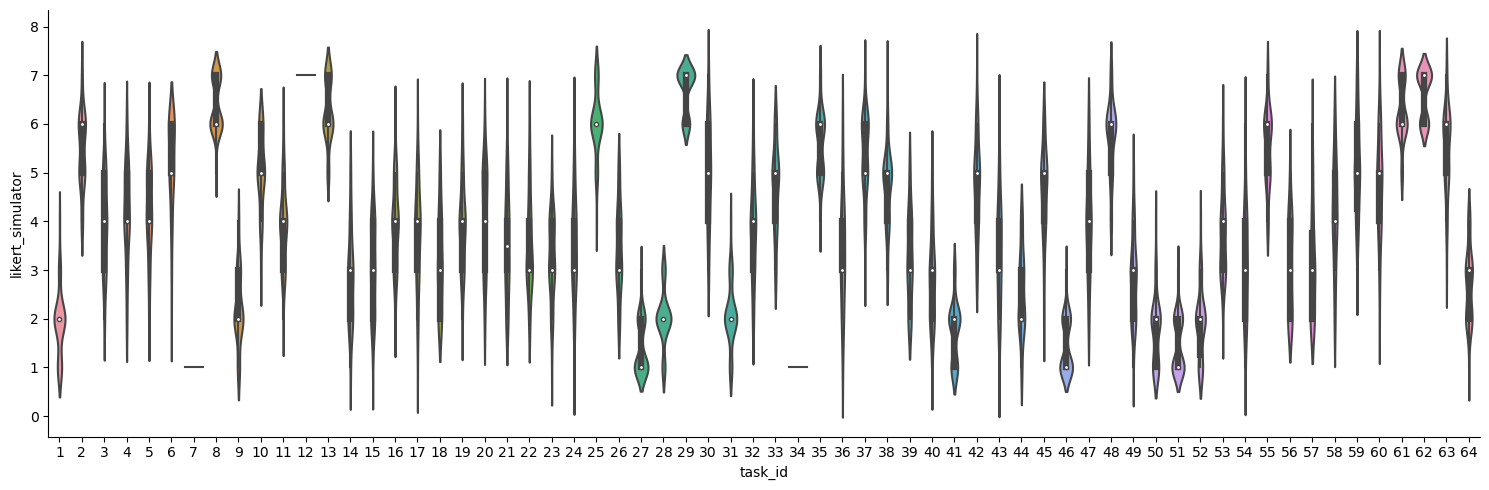

In [6]:
sns.catplot(data=df_data, x="task_id", y="likert_simulator", kind="violin", aspect=3)

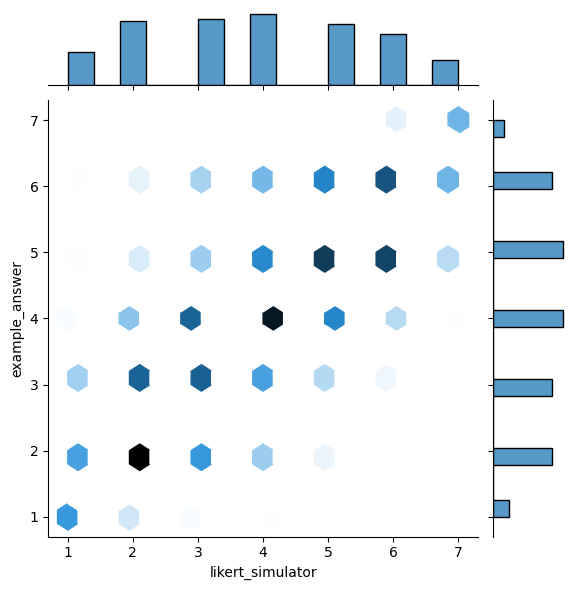

In [7]:
sns.jointplot(data=df_data, x="likert_simulator", y="example_answer", kind="hex")

<AxesSubplot: xlabel='likert_simulator', ylabel='example_answer'>

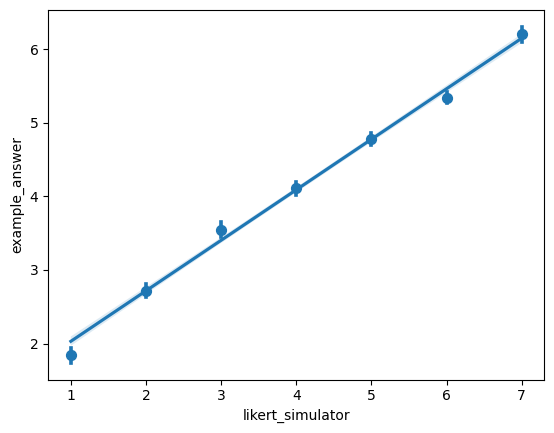

In [8]:
sns.regplot(data=df_data, x="likert_simulator", y="example_answer", x_estimator=np.mean)

In [9]:
df_human_mean = df_human.groupby("task_id").mean("likert_human")
df_human_mean

,run_id,condition,likert_human
task_id,,,
1,53.615385,2.0,2.153846
2,54.478261,1.0,5.173913
3,51.954545,4.0,4.045455
4,57.130435,3.0,3.434783
5,57.130435,3.0,4.000000
...,...,...,...
60,53.615385,2.0,4.384615
61,51.954545,4.0,5.500000
62,54.478261,1.0,6.347826


<AxesSubplot: xlabel='likert_simulator', ylabel='likert_human'>

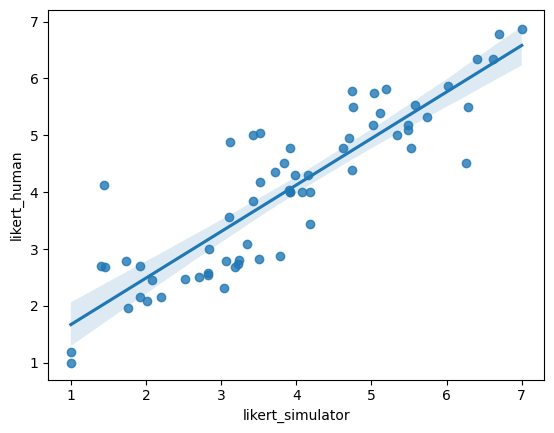

In [10]:
df_simulator_mean = df_data.groupby("task_id").mean("likert")
df_human_mean = df_human.groupby("task_id").mean("likert_human")
df_comparison = df_simulator_mean.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison, x="likert_simulator", y="likert_human")

In [11]:
rho, pval = pearsonr(df_comparison["likert_simulator"].tolist(), df_comparison["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

0.8827578254286181 5.20568075871956e-22
0.7792613783554626


In [12]:
def transform_probs_to_likert(probs):
    return np.dot(probs, np.array([1, 2, 3, 4, 5, 6, 7]))

df_baseline_zeroshot["likert_baseline_zeroshot"] = df_baseline_zeroshot["probs"].apply(transform_probs_to_likert)

<AxesSubplot: >

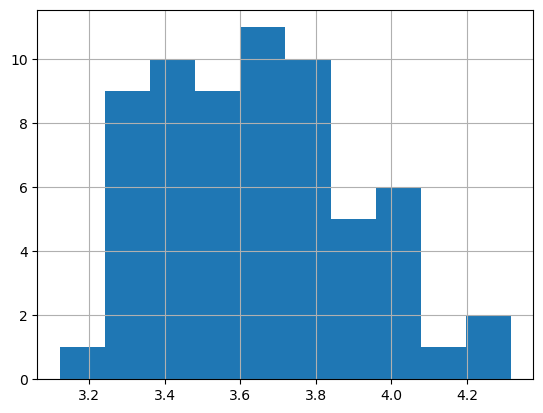

In [13]:
df_baseline_zeroshot["likert_baseline_zeroshot"].hist()

<AxesSubplot: xlabel='likert_baseline_zeroshot', ylabel='likert_human'>

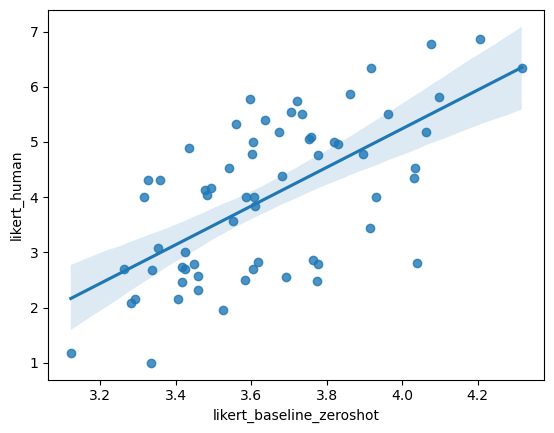

In [14]:
df_comparison_baseline = df_baseline_zeroshot.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison_baseline, x="likert_baseline_zeroshot", y="likert_human")

In [15]:
rho, pval = pearsonr(df_comparison_baseline["likert_baseline_zeroshot"].tolist(), df_comparison_baseline["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

0.6406995102263146 1.183491925284721e-08
0.41049586240423935
